<a href="https://colab.research.google.com/github/maazbinadnan/Neural-Networks/blob/main/word2veccuda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np
from numba import cuda
from nltk.corpus import stopwords
from nltk.corpus import brown
import re
numberembeddings =10

In [ ]:
corpus ="Batman is a superhero appearing in American comic books published by DC Comics. The character was created by artist Bob Kane and writer Bill Finger, and debuted in the 27th issue of the comic book Detective Comics on March 30, 1939. In the DC Universe continuity, Batman is the alias of Bruce Wayne, a wealthy American playboy, philanthropist, and industrialist who resides in Gotham City. Batman's origin story features him swearing vengeance against criminals after witnessing the murder of his parents Thomas and Martha as a child, a vendetta tempered with the ideal of justice. He trains himself physically and intellectually, crafts a bat-inspired persona, and monitors the Gotham streets at night. Kane, Finger, and other creators accompanied Batman with supporting characters, including his sidekicks Robin and Batgirl; allies Alfred Pennyworth, James Gordon, and Catwoman; and foes such as the Penguin, the Riddler, Two-Face, and his archenemy, the Joker. Kane conceived Batman in early 1939 to capitalize on the popularity of DC's Superman; although Kane frequently claimed sole creation credit, Finger substantially developed the concept from a generic superhero into something more bat-like. The character received his own spin-off publication, Batman, in 1940. Batman was originally introduced as a ruthless vigilante who frequently killed or maimed criminals, but evolved into a character with a stringent moral code and strong sense of justice. Unlike most superheroes, Batman does not possess any superpowers, instead relying on his intellect, fighting skills, and wealth. The 1960s Batman television series used a camp aesthetic, which continued to be associated with the character for years after the show ended. Various creators worked to return the character to his darker roots in the 1970s and 1980s, culminating with the 1986 miniseries The Dark Knight Returns by Frank Miller.DC has featured Batman in many comic books, including comics published under its imprints such as Vertigo and Black Label. The longest-running Batman comic, Detective Comics, is the longest-running comic book in the United States. Batman is frequently depicted alongside other DC superheroes, such as Superman and Wonder Woman, as a member of organizations such as the Justice League and the Outsiders. In addition to Bruce Wayne, other characters have taken on the Batman persona on different occasions, such as Jean-Paul Valley / Azrael in the 1993–1994 story arc; Dick Grayson, the first Robin, from 2009 to 2011; and Jace Fox, son of Wayne's ally Lucius, as of 2021.[4] DC has also published comics featuring alternate versions of Batman, including the incarnation seen in The Dark Knight Returns and its successors, the incarnation from the Flashpoint (2011) event, and numerous interpretations from Elseworlds stories.One of the most iconic characters in popular culture, Batman has been listed among the greatest comic book superheroes and fictional characters ever created. He is one of the most commercially successful superheroes, and his likeness has been licensed and featured in various media and merchandise sold around the world; this includes toy lines such as Lego Batman and video games like the Batman: Arkham series. Batman has been adapted in live-action and animated incarnations, including the 1960s Batman television series played by Adam West and in film by Michael Keaton in Batman (1989), Batman Returns (1992), and The Flash (2023), Val Kilmer in Batman Forever (1995), George Clooney in Batman and Robin (1997), Christian Bale in The Dark Knight trilogy (2005–2012), Ben Affleck in the DC Extended Universe (2016–present), and Robert Pattinson in The Batman (2022). Kevin Conroy, Diedrich Bader, Jensen Ackles, Troy Baker, and Will Arnett, among others, have provided the character's voice."
#preprocessing and removing any stopwords
def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    tokens = pattern.findall(text.lower())

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    return tokens

text = tokenize(corpus)
print(text)
print(len(text))
vocabsize = len(text)


['batman', 'superhero', 'appearing', 'american', 'comic', 'books', 'published', 'dc', 'comics', 'character', 'created', 'artist', 'bob', 'kane', 'writer', 'bill', 'finger', 'debuted', '27th', 'issue', 'comic', 'book', 'detective', 'comics', 'march', 'dc', 'universe', 'continuity', 'batman', 'alias', 'bruce', 'wayne', 'wealthy', 'american', 'playboy', 'philanthropist', 'industrialist', 'resides', 'gotham', 'city', "batman's", 'origin', 'story', 'features', 'swearing', 'vengeance', 'criminals', 'witnessing', 'murder', 'parents', 'thomas', 'martha', 'child', 'vendetta', 'tempered', 'ideal', 'justice', 'trains', 'physically', 'intellectually', 'crafts', 'bat', 'inspired', 'persona', 'monitors', 'gotham', 'streets', 'night', 'kane', 'finger', 'creators', 'accompanied', 'batman', 'supporting', 'characters', 'including', 'sidekicks', 'robin', 'batgirl', 'allies', 'alfred', 'pennyworth', 'james', 'gordon', 'catwoman', 'foes', 'penguin', 'riddler', 'two', 'face', 'archenemy', 'joker', 'kane', '

In [ ]:
def mapping(preprocessedtext):
    wordtoid=dict()
    idtoword=dict()
    for i in range(len(preprocessedtext)):
        wordtoid[preprocessedtext[i]]=i

        idtoword[i]=preprocessedtext[i]
    return wordtoid,idtoword
wordtoid,idtoword=mapping(text)

# print(wordtoid)
# print(idtoword)

In [ ]:
def one_hot_encode(id, vocab_size):
    res = [0] * vocab_size
    res[id] = 1
    return res

def concat(*iterables):
    result = []
    for iterable in iterables:
        result.extend(iterable)
    return result



In [ ]:
np.random.seed(42)

def generate_training_data(tokens, word_to_id, window):
    X = []
    y = []
    n_tokens = len(tokens)

    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i),
            range(i, min(n_tokens, i + window + 1))
        )
        for j in idx:
            if i == j:
                continue
            X.append(one_hot_encode(word_to_id[tokens[i]], len(tokens)))
            y.append(one_hot_encode(word_to_id[tokens[j]], len(tokens)))

    return np.asarray(X), np.asarray(y)

x,y = generate_training_data(text,word_to_id=wordtoid, window=2)
print(x.shape)
print(y.shape)


(1438, 361)
(1438, 361)


defining functions

In [ ]:
np.random.seed(42)

def init_network(vocabsize,n_embedding):
    model={
        'W1':np.random.randn(vocabsize,n_embedding),
        'W2':np.random.randn(n_embedding,vocabsize)
        }
    return model
model=init_network(vocabsize,numberembeddings)
print(model['W1'].shape[1])



10


In [ ]:
def softmax(matrix):
    max_val = np.max(matrix, axis=1, keepdims=True)
    matrix_exp = np.exp(matrix - max_val)
    matrix_sum = np.sum(matrix_exp, axis=1, keepdims=True)
    result = matrix_exp / matrix_sum
    return result


In [ ]:
#forward prop
def output(model,X,returncache=True):
    cache ={}
    cache['z1']=np.dot(X,model['W1'])
    cache['z2'] = np.dot(cache["z1"],model["W2"])
    cache['probs'] = softmax(cache["z2"])
    if not returncache:
        return cache['z1']
    return cache

In [ ]:
@cuda.jit
def matrix_multiply(A, B, C):
    i, j = cuda.grid(2)
    if i < C.shape[0] and j < C.shape[1]:
        temp = 0.0
        for k in range(A.shape[1]):
            temp += A[i, k] * B[k, j]
        C[i, j] = temp


In [ ]:
def forwardprop_using_cuda(input_matrix, weight_matrix1, weight_matrix2,returncache=True):
    # Transfer input matrices to the GPU
    x_input_cuda = cuda.to_device(input_matrix)
    w1_input_cuda = cuda.to_device(weight_matrix1)
    w2_input_cuda = cuda.to_device(weight_matrix2)

    # Create CUDA device arrays for intermediate results
    z1_cuda = cuda.device_array((input_matrix.shape[0], weight_matrix1.shape[1]), dtype=np.float64)
    z2_cuda = cuda.device_array((input_matrix.shape[0], weight_matrix2.shape[1]), dtype=np.float64)

    # Set the block and grid dimensions
    threadsperblock = (16, 16)
    blockspergrid_x = (input_matrix.shape[0] + threadsperblock[0] - 1) // threadsperblock[0]
    blockspergrid_y = (weight_matrix1.shape[1] + threadsperblock[1] - 1) // threadsperblock[1]
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    # Launch the kernel for the first matrix multiplication
    matrix_multiply[blockspergrid, threadsperblock](x_input_cuda, w1_input_cuda, z1_cuda)
    cuda.synchronize()
    blockspergrid_x = (input_matrix.shape[0] + threadsperblock[0] - 1) // threadsperblock[0]
    blockspergrid_y = (weight_matrix2.shape[1] + threadsperblock[1] - 1) // threadsperblock[1]
    blockspergrid = (blockspergrid_x, blockspergrid_y)
    matrix_multiply[blockspergrid, threadsperblock](z1_cuda, w2_input_cuda, z2_cuda)
    cuda.synchronize()

    # Copy the final result back to the host
    cache = {}
    cache['z1'] = z1_cuda.copy_to_host()
    cache['z2'] = z2_cuda.copy_to_host()
    cache['probs'] = softmax(cache["z2"])
    if not returncache:
        return cache['probs']
    return cache

In [ ]:
# print(forwardprop_using_cuda(x,model['W1'],model['W2'],False)[9])

In [ ]:
def cross_entropy(z, y, epsilon=1e-10):
    z_safe = np.clip(z, epsilon, 1.0 - epsilon)
    return -np.sum(np.log(z_safe) * y)


In [ ]:
def backward(model, X, y, alpha):
    cache  = forwardprop_using_cuda(X,model['W1'],model['W2'],True)
    #cache  = output(model, X)
    da2 = cache["probs"] - y
    dw2 = cache["z1"].T @ da2
    da1 = da2 @ model["W2"].T
    dw1 = X.T @ da1
    assert(dw2.shape == model["W2"].shape)
    assert(dw1.shape == model["W1"].shape)
    model["W1"] -= alpha * dw1
    model["W2"] -= alpha * dw2
    return cross_entropy(cache["probs"], y)

In [ ]:
def backward(model, X, y, alpha):
    #cache  = forwardprop_using_cuda(X,model['W1'],model['W2'],True)
    cache  = output(model, X)
    da2 = cache["probs"] - y
    dw2 = cache["z1"].T @ da2
    da1 = da2 @ model["W2"].T
    dw1 = X.T @ da1
    assert(dw2.shape == model["W2"].shape)
    assert(dw1.shape == model["W1"].shape)
    model["W1"] -= alpha * dw1
    model["W2"] -= alpha * dw2
    return cross_entropy(cache["probs"], y)

C:\Users\HP\AppData\Local\Temp\ipykernel_12504\1503733050.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


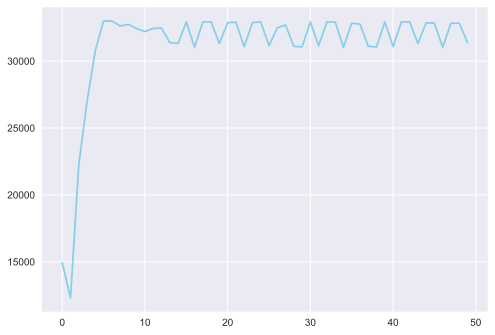

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use("seaborn")

n_iter = 50
learning_rate = 0.05

history = [backward(model, x, y, learning_rate) for _ in range(n_iter)]

plt.plot(range(len(history)), history, color="skyblue")
plt.show()

In [ ]:
learning = one_hot_encode(wordtoid["batman"], len(text))
result = output(model, [learning],False)[0]

for word in (idtoword[id] for id in np.argsort(result)[::-1]):
    print(word)

batman
superhero
dc
comic
appearing
comics
books
character
american
published


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import nltk
from torch.utils.data import DataLoader
from gensim.models import Word2Vec

# Download the Brown corpus from NLTK
nltk.download('brown')

# Load the Brown corpus
from nltk.corpus import brown
sentences = brown.sents()

# Create word_to_index mapping
word_to_index = {}
for sentence in sentences:
    for word in sentence:
        if word not in word_to_index:
            word_to_index[word] = len(word_to_index)

# Convert sentences to word indices
word_indices = [[word_to_index[word] for word in sentence] for sentence in sentences]

# Set device to CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the Word2Vec model architecture
class Word2VecModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2VecModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        return embeds

# Define model parameters
vocab_size = len(word_to_index)
embedding_dim = 100
num_epochs = 10

# Create DataLoader for batching and shuffling
dataloader = DataLoader(word_indices, batch_size=128, shuffle=True)

# Create Word2Vec model
model = Word2VecModel(vocab_size, embedding_dim).to(device)

# Training loop
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
for epoch in range(num_epochs):
    for batch in dataloader:
        batch = batch.to(device)

        # Forward pass
        embeddings = model(batch)
        targets = batch.view(-1)
        loss = criterion(embeddings.view(-1, vocab_size), targets)

        # Backward pass and update model weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Save the trained model
torch.save(model.state_dict(), 'word2vec_model_cuda.pth')


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


KeyboardInterrupt: 